In [182]:
#from PyQt5.QtWidgets import *
#from PyQt5.QtGui import *
#from PyQt5.QtCore import Qt
import os
from array import array
import numpy as np
from commpy.filters import rcosfilter
from commpy.filters import rrcosfilter
import matplotlib
import matplotlib.pyplot as plt
import ipympl
#%matplotlib inline
%matplotlib widget

In [183]:
#import matplotlib
#import matplotlib.pyplot as plt
#import numpy as np
#import cmath
#import math
#from commpy.filters import rcosfilter
#from ipywidgets import interact, widgets

In [184]:
from scipy.signal import butter, filtfilt
import os
from array import array
def read_signal(file_name, data_type):
    file_stats = os.stat(file_name)
    file_size = file_stats.st_size
    iq_size_in_bytes = 4
    number_of_int_to_read = file_size // iq_size_in_bytes * 2
    arr = array(data_type)
    with open(file_path, 'rb') as fileobj:
        arr.fromfile(fileobj, number_of_int_to_read)
    i = np.array(arr[:: 2])
    i = i.reshape((len(i), 1))
    q = np.array(arr[1:: 2])
    q = q.reshape((len(q), 1))
    sig = np.empty((len(i), 1), complex)
    sig.real = i
    sig.imag = q
    sig_flatten = sig.flatten()
    return sig_flatten


def find_carr_freq(spectrum, min_sig_lvl):
    idx = list(np.where(spectrum >= min_sig_lvl))
    idx = idx[0]
    f_low = idx[0]
    f_high = idx[-1]
    carr_freq = round((f_low + f_high) / 2)
    return carr_freq


def mixing_signal(signal, freq):
    N = len(signal)
    k = freq
    n = np.arange(0, N, 1)
    mixer = np.exp(-1j * 2 * math.pi * k * n / N)
    mixed_signal = np.multiply(signal, mixer)
    return mixed_signal


def filter_signal(mixed_sig, normal_cutoff):
    order = 2
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    sig_filtered = filtfilt(b, a, mixed_sig)
    return sig_filtered

In [185]:
def resampling_lagrange_step_ver(s, step, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    #if (p > 1):
    #    if (q == 1):
    #        y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
    #    else:
    #        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    #else:
    #    y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    if (step > 1):
        y = np.zeros(int((len(s) -1) / step) + 1, dtype=np.csingle)
    else:
        y = np.zeros(int(len(s) / step), dtype=np.csingle) 
    
    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    print(f"len(y) = {len(y)}, len(t) = {len(t)}, len(s) = {len(s)}")

    for k in range(len(y)):
        #x = k * q / p - x0
        x = k * step - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        #print(f"x = {x}, n = {n}, d = {d}")
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1
        #print(f"a0 = {a0} a1 = {a1} a2 = {a2} a3 = {a3}")
        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    #print(t)
    return y

In [186]:
def resampling_lagrange(s, p, q, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    if (p > 1):
        if (q == 1):
            y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
        else:
            y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    else:
        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)

    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    for k in range(len(y)):
        x = k * q / p - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1

        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    return y


In [187]:
def calculate_spectrum(signal):
    yf = np.fft.fft(signal)
    yf = np.abs(yf.reshape((len(yf), 1))) / len(signal)
    return yf


def plot_spectrum(signal, figure_counter, title="Amplitude spectrum"):
    spectrum = np.roll(calculate_spectrum(signal), len(signal) // 2)
    yf = 20 * np.log10(spectrum)

    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(-len(spectrum) // 2 + 1, len(spectrum) // 2 + 1)
    x_data = x_data / (len(spectrum) / 2)
    plt.plot(x_data, yf)
    plt.grid(1)
    plt.xlabel('Frequency (semicircles)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    plt.show()
    return yf

def add_freq(sig, f0_to_fsig):
    n = np.arange(0, len(sig), 1)
    mixer = np.exp(1j * np.pi * f0_to_fsig * n)
    #print(mixer[(821500 - 10 -1) : (821500 - 1)])
    return sig * mixer

In [188]:
def gen_rrc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
    print(n * f_sampl)
    print(roll_off)
    print(t_symb)    
    print(f_sampl)
    
    s_psf = rrcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
    print(s_psf)
    #plt.figure()
    #plt.plot(s_psf, '*-')
    #plt.grid()
    #plt.title('RC filter impulse response')
    #plt.show()
    return s_psf

In [189]:
def gen_rc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
    #print(n * f_sampl)
    #print(roll_off)
    #print(t_symb)    
    #print(f_sampl)
    
    s_psf = rcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
    #print(s_psf)
    #plt.figure()
    #plt.plot(s_psf, '*-')
    #plt.grid()
    #plt.title('RC filter impulse response')
    #plt.show()
    return s_psf

In [190]:
def add_phase(sig, phase):
# phase = [-1, 1] [semicircles]
    sig *= np.exp(1j * np.pi * phase)
    return sig

In [191]:
def save_cmplx_sig_to_int16(signal, filename):
    s_re = signal.real
    s_im = signal.imag
    arr_int16_re = s_re.astype(np.int16)
    arr_int16_im = s_im.astype(np.int16)
    arr_int = np.empty(len(two_sigs) * 2, dtype=int)
    print(len(arr_int))
    arr_int[ : : 2] = arr_int16_re
    arr_int[1 : : 2] = arr_int16_im
    saved_arr = arr_int.astype(np.int16)
    print(saved_arr[:30])
    with open(filename, 'wb') as f:
        saved_arr.tofile(f)

In [192]:
def gen_qpsk_symbols(n_symb, fs):
    # create IQ of QPSK
    # complex array: [(1 + 1j, 1 -1j, ..., -1 -1j)]
    data = np.random.randint(0, 4, n_symb)
    #print(len(data))
    #x_tr = x.transpose()
    y = [-1 - 1j, -1 + 1j, 1 - 1j, 1 + 1j]
    iq = [y[val] for val in data]
    iq_ups = np.zeros(n_symb * fs, dtype=complex)
    iq_ups[:len(iq) * fs:fs] = iq
    return iq_ups

In [193]:
def plot_signal_power(signal, figure_counter, title="Signal Power"):
    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(0, len(signal))
    plt.plot(x_data, signal)
    plt.grid(1)
    plt.xlabel('time (samples)')
    plt.ylabel('Signal Power')
    plt.title(title)
    plt.show()

def upscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * np.floor(coeff)

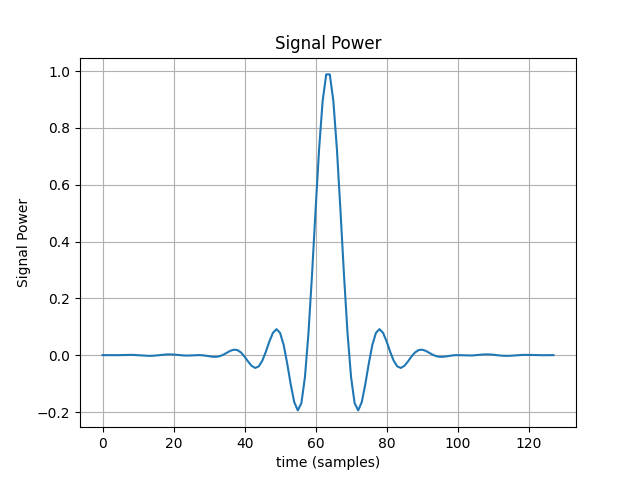

In [202]:
sig_board = 0.168
N = 129#100
Fs = 1
T_symb = 1 / sig_board
s_rc = gen_rc_filter_impulse_response(N, Fs, T_symb)
plot_signal_power(s_rc, 0)


f0 = 2.5 # f_carrier / f_symbol
phase_0 = 3 / 9 # semicircles
delay = 0.1

N_symb = N * 50000
sps = 8 # f_sampling / f_symbol (SPS)
s_qpsk = gen_qpsk_symbols(N_symb, sps)
qpsk_rc = np.convolve(s_qpsk, s_rc, 'same')


In [203]:

mixed_qpsk = add_freq(qpsk_rc, 0.5)
mixed_qpsk = add_phase(mixed_qpsk, 0.3)

In [204]:
two_sigs = mixed_qpsk + qpsk_rc
two_sigs = upscale_to_i16(two_sigs)

(3.6164316924392748-1.1693401277175752j)
3.6164316924392748
3.6137687995083727
9060.588664927536


In [205]:
save_cmplx_sig_to_int16(two_sigs, 'qpsk_rc_int16_.bin')

103200000
[ 21280 -11712   8123   2584  -4376 -10403  10253 -15858  13059   2763
   -342   4505   8396  -2249  17326  14995    319  23818  -5505   5921
  10196  -1468  15516   6561   9379   8171   2655   3536  -1776  -7755]


In [206]:
print(max(two_sigs))

(32764.87113349983-10594.221557121231j)


In [207]:
print(N)
print(Fs)
print(T_symb)
s_rrc = gen_rrc_filter_impulse_response(N, Fs, T_symb)
qpsk_rrc = np.convolve(s_qpsk, s_rrc, 'same')
mixed_qpsk = add_freq(qpsk_rrc, 0.5)
mixed_qpsk = add_phase(mixed_qpsk, 0.3)
two_sigs = mixed_qpsk + qpsk_rrc
two_sigs = upscale_to_i16(two_sigs)
save_cmplx_sig_to_int16(two_sigs, 'qpsk_rrc_int16_.bin')

129
1
5.952380952380952
129
0.24
5.952380952380952
1
[ 2.12139016e-03  3.05028320e-03  2.74618624e-03  1.28787821e-03
 -7.52778102e-04 -2.52515307e-03 -3.24612254e-03 -2.54027082e-03
 -6.29184640e-04  1.72129241e-03  3.49109098e-03  3.82767631e-03
  2.43020365e-03 -2.70537054e-04 -3.22990038e-03 -5.18018186e-03
 -5.15236431e-03 -2.91943273e-03  8.33183579e-04  4.70674585e-03
  7.10794152e-03  6.89862025e-03  3.91582370e-03 -8.68302461e-04
 -5.64784530e-03 -8.46327461e-03 -8.01131503e-03 -4.25649218e-03
  1.43368039e-03  6.73682385e-03  9.28043005e-03  7.67040505e-03
  2.22013916e-03 -4.96793820e-03 -1.06875376e-02 -1.18931899e-02
 -7.08911502e-03  2.72883153e-03  1.40466420e-02  2.18817739e-02
  2.16529474e-02  1.12397913e-02 -7.57663896e-03 -2.89877093e-02
 -4.46382332e-02 -4.64306808e-02 -2.98118523e-02  3.62411618e-03
  4.53248926e-02  8.13987493e-02  9.65315958e-02  7.92387520e-02
  2.68760997e-02 -5.13192570e-02 -1.34481338e-01 -1.94089881e-01
 -2.00962988e-01 -1.33536595e-01  1.4